# Stochastik

In [1]:
import numpy as np
from numpy.random import rand, randint, normal
from sklearn.linear_model import orthogonal_mp as OMP
from scipy.special import factorial, comb

import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from matplotlib import rcdefaults

rcdefaults()
plt.style.use("seaborn-whitegrid")
plt.rcParams["figure.figsize"] = [12.8, 7.2]
plt.rcParams["font.size"] = 12
plt.rcParams["axes.edgecolor"] = "white"
plt.rcParams["legend.frameon"] = True
plt.rcParams["legend.framealpha"] = 0.75
plt.rcParams["legend.facecolor"] = "white"
plt.rcParams["legend.edgecolor"] = "white"

### Poisson Verteilung

Die Wahrscheinlichkeit, in Österreich an einer hochgradig ansteckenden Atemwegserkrankung zu leiden, sei 0,1%. Wie hoch ist die Wahrscheinlichkeit, dass in einem Vorlesungsraum mit 110 Personen genau k erkrankt sind? Wie hoch ist diese Wahrscheinlichkeit für die gesamte Universität Wien mit 90000 Studierenden?

Es seien $p = 0.001$, $n_1 = 110$ und $n_2 = 90000$. Wir setzen $\lambda_1 = n_1 \cdot p = 0.11$ und $\lambda_2 = n_2 \cdot p = 90$. Dann ist die Wahrscheinlichkeit genau $k$ Erkrankte im Vorlesungsraum bzw. an der Universität zu haben, approximativ gegeben durch die Poisson-Verteilung $\pi_\lambda(k) = \frac{\lambda^k}{k!}\cdot e^{-\lambda}$.

Im Folgenden werden die beide Szenarien und zusätzlich die Wahrscheinlichkeiten, dass mindestens $k$ Personen erkrankt sind, geplottet.

In [2]:
def givePoisson(k, rate):
    indices = np.arange(k)
    probs = rate**indices / factorial(indices) * np.exp(-rate)
    return probs

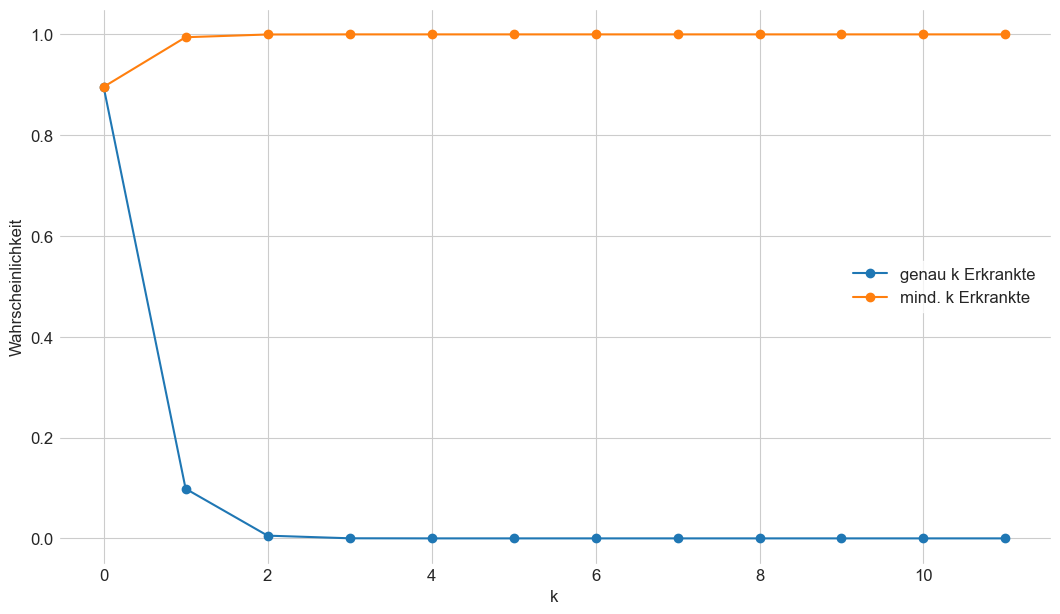

In [3]:
p = 0.001
stud_one_room = 110
stud_UniWien = 90_000
lambda1 = stud_one_room * p
lambda2 = stud_UniWien * p

probs = givePoisson(12, lambda1)

indices = np.arange(12)
plt.plot(indices, probs, "o-", label="genau k Erkrankte")
plt.plot(indices, np.cumsum(probs), "o-", label="mind. k Erkrankte")
plt.xlabel("k")
plt.ylabel("Wahrscheinlichkeit")
plt.legend()
plt.show()

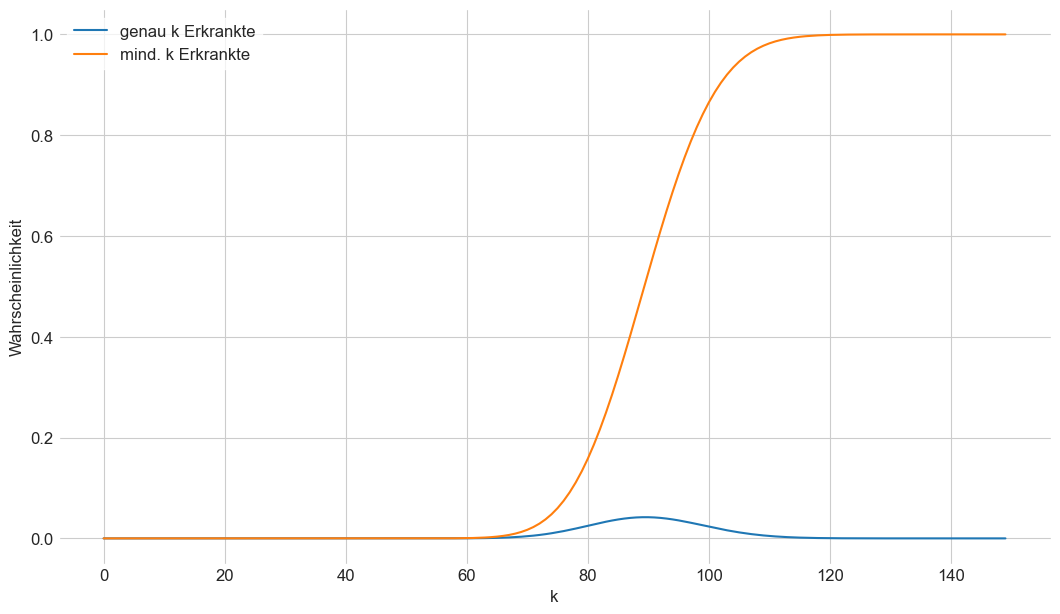

In [4]:
probs = givePoisson(150, lambda2)

indices = np.arange(150)
plt.plot(indices, probs, label="genau k Erkrankte")
plt.plot(indices, np.cumsum(probs), label="mind. k Erkrankte")
plt.xlabel("k")
plt.ylabel("Wahrscheinlichkeit")
plt.legend()
plt.show()

### Polya Verteilung 

Die Universität Wien und die TU Wien werben um Studierende. Sobald sich eine Person für eine der Universitäten entschieden hat, ist sie sofort so von ihrer Wahl überzeugt, dass sie dieses mit allen anderen teilt. Dabei steigt die Wahrscheinlichkeit, dass sich andere für die selbe Universität entscheiden.

In [18]:
def givePolya(red, blue, maxN, increment):
    distr = comb(maxN, np.arange(maxN+1))
    
    for k in range(maxN+1):
        for ell in range(k):
            distr[k] *= (red + ell * increment) / (red + blue + ell * increment)
        
        for ell in range(k, maxN):
            distr[k] /= (red + blue + ell * increment)
        
        for ell in range(maxN - k):
            distr[k] *= (blue + ell * increment)
            
    return distr

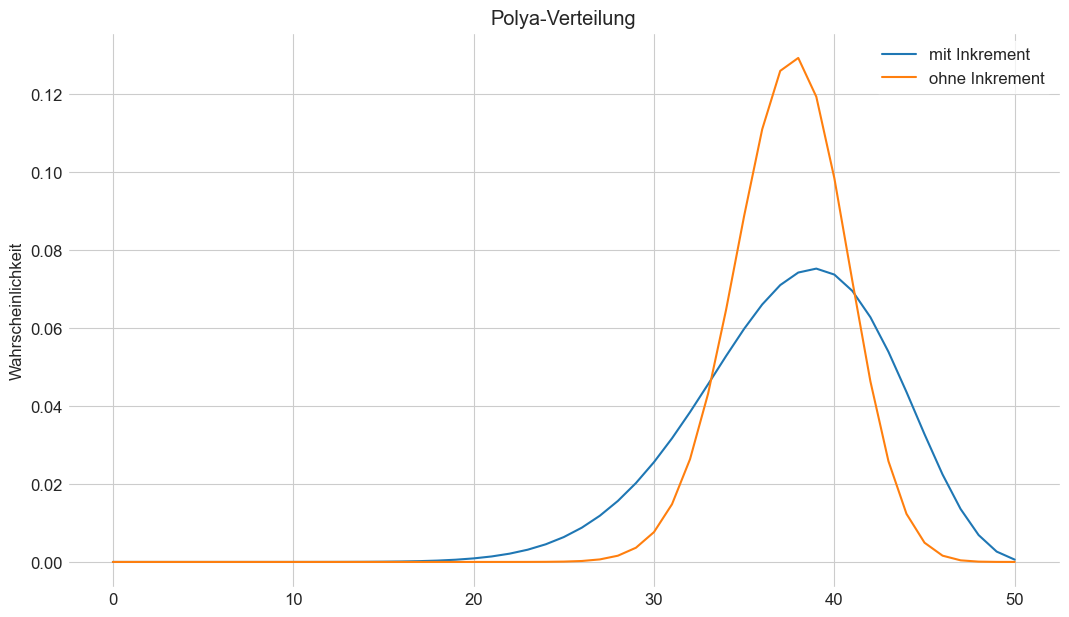

In [23]:
UniWien = 90_000
TUWien = 30_000
maxN = 50
distr1 = givePolya(UniWien, TUWien, maxN, 5000)
distr2 = givePolya(UniWien, TUWien, maxN, 0)

x = np.arange(maxN+1)
plt.plot(x, distr1, label="mit Inkrement")
plt.plot(x, distr2, label="ohne Inkrement")
plt.ylabel("Wahrscheinlichkeit")
plt.title("Polya-Verteilung")
plt.legend()
plt.show()

### Markov Ketten

Sei $I$ abzählbar, $(X_n)_{n\in\mathbb{N}}$ eine Folge von Zufallsgrößen mit Werten in $I$ und $(\Omega,\ \mathcal{F},\ P)$ der zugrundeliegende Wahrscheinlichkeits-Raum.

$(X_n)_{n\in\mathbb{N}}$ heißt *Markov-Kette* mit Zustandsraum $I$, falls für alle $n\in\mathbb{N}$ und alle $i_0,\ i_1,\ ...,\ i_n,\ i_{n+1}\in I$ mit $P(X_0=i_0,\ ...,\ X_n=i_n) > 0$ die sogenannte Markov-Eigenschaft erfüllt ist:

\begin{equation*}
    P(X_{n+1}=i_{n+1}\ |\ X_n=i_n,\ ...,\ X_0=i_0) = P(X_{n+1}=i_{n+1}\ |\ X_n=i_n)
\end{equation*}

Eine Markov-Kette heißt *homogen*, falls für alle $i,j\in I$ die Wahrscheinlichkeit $P(X_{n+1}=j\ |\ X_n=i)$ unabhängig von $n$ ist.

Für eine Markov-Kette $(X_n)_{n\in\mathbb{N}}$ mit Zustandsraum $I$ nennen wir $p_{ij} := P(X_{n+1}=j,\ X_n=i)$ die *Übergangswahrscheinlichkeit* vom Zustand $i$ in den Zustand $j$. Die Matrix $(p_{ij})_{i,j\in I}$ heißt dann *Übergangsmatrix*.

Die Verteilung von $X_0$ heißt *Anfangsverteilung* und für $n\in\mathbb{N}$ heißen die gemeinsamen Verteilungen von $X_0,\ ...,\ X_n$ *endlich-dimensionale Verteilungen*.

Eine Markov-Kette $(X_n)_{n\in\mathbb{N}}$ heißt *stationär*, falls für beliebige $m\in\mathbb{N}$ $(X_n)_{n\in\mathbb{N}}$ und $(X_n+m)_{n\in\mathbb{N}}$ die gleichen endlich-dimensionalen Verteilungen besitzen.

Im Folgenden werden für eine zufällige Übergangsmatrix und für eine zufällige Anfangsverteilung die endlich-dimensionalen Verteilungen berechnet und zusammen mit den stationären Verteilungen geplottet.

In [7]:
def simulateMarkovChain(n, steps):
    
    # random stochastic matrix
    A = rand(n, n)
    for k in range(n):
        A[k] = A[k] / sum(A[k])
    
    # stationary distribution calculation
    eigvals, eigvects = np.linalg.eig(A.T)  # transposed to get left eigenvector
    k = eigvals.argsort()[-1]
    stat = np.abs(eigvects[:,k] / sum(eigvects[:,k]))
    
    # random initial distribution
    p0 = rand(n)
    
    # distribution calculation for each step
    distr = np.zeros((steps, n))
    distr[0] = p0 / sum(p0)
    for step in range(1, steps):
        distr[step] = distr[step-1] @ A
    
    return distr, stat

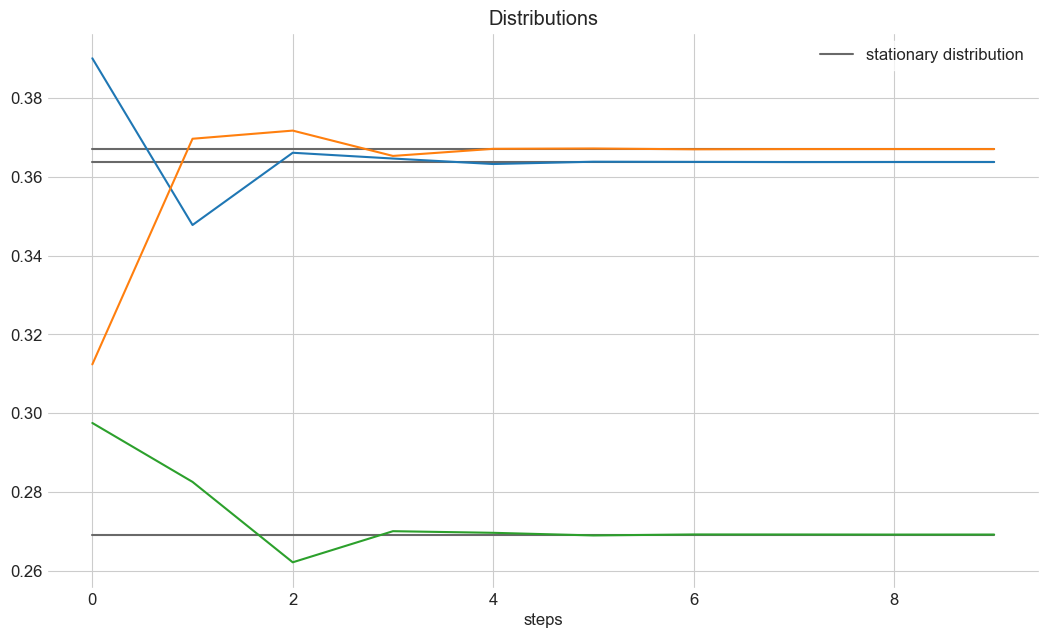

In [8]:
n = 3
steps = 10
distr, stat = simulateMarkovChain(n, steps)

x = np.arange(steps)
y = np.ones(steps)
for p in stat[:-1]:
    plt.plot(x, p*y, "dimgray")
plt.plot(x, stat[-1]*y, "dimgray", label="stationary distribution")
plt.plot(x, distr)
plt.title("Distributions")
plt.xlabel("steps")
plt.legend()
plt.show()

### Random Walk

Sei $(\xi_n)_{n\in\mathbb{N}}$ eine Folge unabhängiger, identisch verteilter Zufallsgrößen mit Werten in $\{z\in \mathbb{Z}^d\ :\ |z|=1\}$. Wir setzen $X_n := \sum_{i=1}^n \xi_i$. Dann ist $(X_n)_{n\in\mathbb{N}}$ eine Markov-Kette mit den Übergangswahrscheinlichkeiten $p_{ij} =
\begin{cases} \frac{1}{2d}, \quad \text{falls } |i-j|=1 \\
0,\quad \text{sonst}\end{cases}$ und nennen sie eine einfache, symmetrische Irrfahrt (Random Walk) auf $\mathbb{Z}^d$.

In [9]:
def randomWalk(N, dim=1, start=None):
    start = np.zeros(dim) if start == None else start
    dirs = np.concatenate((np.eye(dim), -np.eye(dim)))
    rand_nums = randint(dim*2, size=N)
    rand_dirs = np.concatenate(([np.array(start)], dirs[rand_nums]))
    walk = np.cumsum(rand_dirs, axis=0)
    walk = walk.flatten() if dim == 1 else walk
    return walk.T

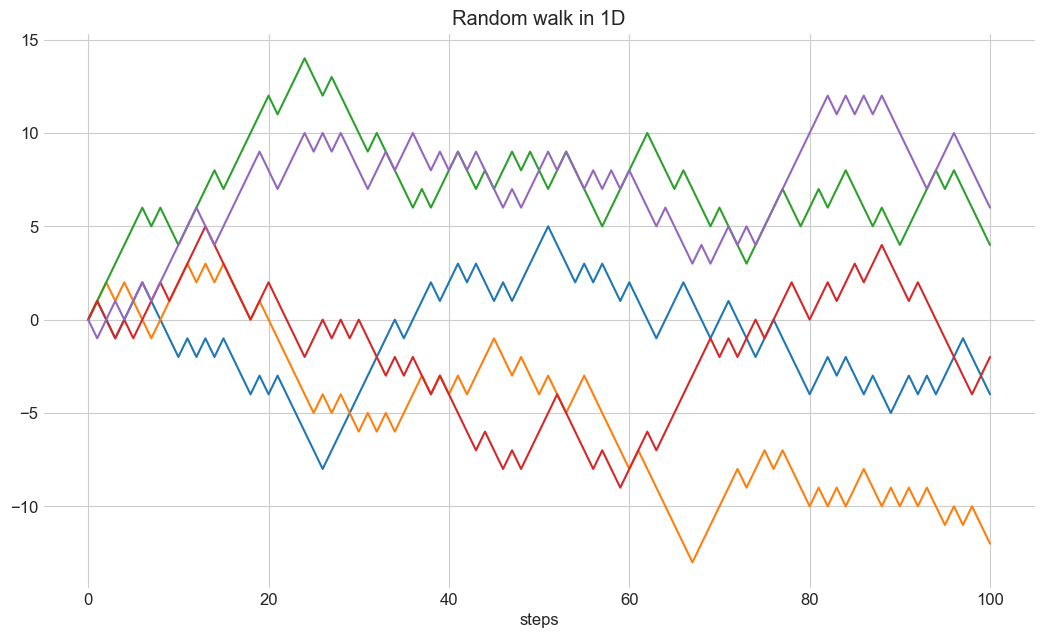

In [10]:
for _ in range(5):
    walk = randomWalk(100)
    plt.plot(walk)
    
plt.title("Random walk in 1D")
plt.xlabel("steps")
plt.show()

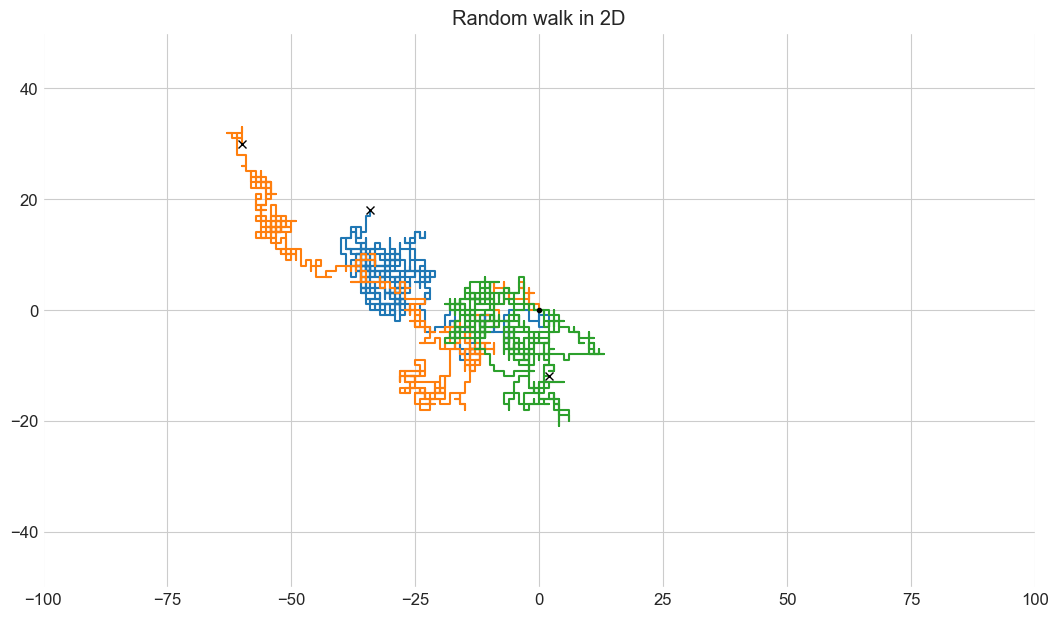

In [11]:
for _ in range(3):
    walk = randomWalk(1000, dim=2)
    plt.plot(walk[0], walk[1])
    plt.plot(walk[0,-1], walk[1,-1], "xk", zorder=3)
    
plt.plot(0, 0, ".k")
plt.axis([-100,100,-50,50])
plt.title("Random walk in 2D")
plt.show()

### Einfaches Markov-SIR Modell

Mit diesem stark vereinfacht dargestellten Modell kann man die Entwicklung einer Krankheit in einer Gesamtbevölkerung von $N$ Personen modellieren. Dabei verwenden wir die folgenden Kürzel:

$S$ ... susceptible: empfänglich für die Krankheit

$I$ ... infected: infiziert mit der Krankheit

$R$ ... removed: entfernt, also entweder genesen und daruch immun oder verstorben

Wir haben somit den Zustandraum $\big\{(S,I,R)\ |\ S,I,R \in \{0,...,N\}\big\}$. Es gilt

\begin{equation*}
X_{n+1} = \begin{pmatrix} S_{n+1} \\ I_{n+1} \\ R_{n+1} \end{pmatrix} = \begin{pmatrix} S_n - M_n \\ I_n + M_n - Q_n \\ R_n + Q_n \end{pmatrix},
\end{equation*}

wobei wir für eine Folge von unabhängigen, aber nicht zwangsläufig identisch verteilten Zufallsgrößen $(\gamma_n)_{n\in\mathbb{N}}$ und für eine unabhängige, identisch verteilte Zufallsgröße $(r_n)_{n\in\mathbb{N}}$ die Werte $M_n := \frac{S_n}{N}\cdot I_n\cdot \gamma_n$ und $Q_n:=I_n\cdot r_n$ definieren.

Die Zahl $M_n$ entspricht der Anzahl der Neuerkrankten im $(n+1)$-ten Schritt, $\gamma_n$ einem Infektionsrisiko und $Q_n$ einer Genesungs- bzw. Todesrate. Damit lässt sich zeigen, dass $(X_n)_{n\in\mathbb{N}}$ eine Markov-Kette ist. Da sich im Verlauf der Krankheit das Infektionsrisiko $\gamma_n$ durchaus ändern kann, ist diese Markov-Kette nicht zwangsläufig homogen.

Im Folgenden werden für den gewählten Startwert $X_0 = (8 800 000, 1600, 15 000)$ und konstanter Infektionsrate von $12\%$ mehrere Simulationen durchlaufen und der Erwartungswert geplottet.

In [12]:
def simulateSIR(time, rate, population, infected, removed):
    S = population - infected - removed
    I = infected
    R = removed
    timeline = np.zeros((time, 3))
    timeline[0] = [S, I, R]
    for t in range(1, time):
        newRemoved = np.floor(I * rand()/10)
        newInfected = np.floor(min(max(S * I / population * normal(rate, rate/2), 0), S))
        
        S = max(S - newInfected, 0)
        I = max(I + newInfected - newRemoved, 0)
        R = max(R + newRemoved, 0)
        
        timeline[t] = [S, I, R]
    
    return timeline.T

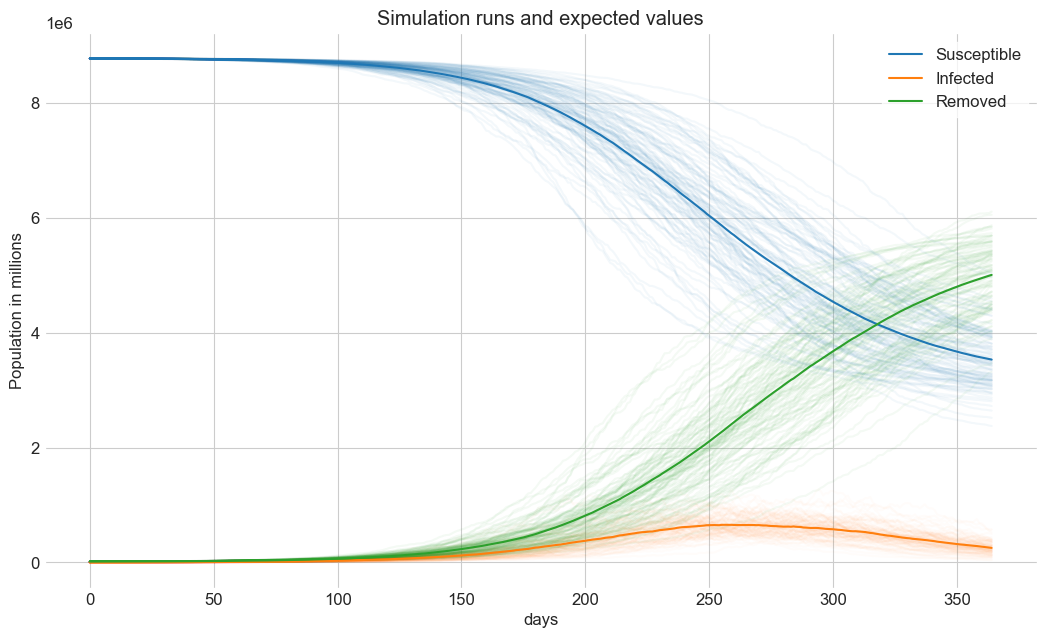

In [13]:
number_of_days = 365
infectionRate = 0.08
population = 8_800_000
infected_at_start = 1600
removed_at_start = 15_000
runs = 100

days = np.arange(number_of_days)
expval = np.zeros((3, number_of_days))
for _ in range(runs):
    timeline = simulateSIR(number_of_days, infectionRate, population, infected_at_start, removed_at_start)
    plt.plot(days, timeline[0], "C0", alpha=0.05)
    plt.plot(days, timeline[1], "C1", alpha=0.02)
    plt.plot(days, timeline[2], "C2", alpha=0.05)
    expval += timeline / runs

plt.plot(days, expval[0], color="C0", label="Susceptible")
plt.plot(days, expval[1], color="C1", label="Infected")
plt.plot(days, expval[2], color="C2", label="Removed")

plt.title("Simulation runs and expected values")
plt.xlabel("days")
plt.ylabel("Population in millions")
plt.legend()
plt.show()

### Maximum Schätzer

Wir möchten feststellen, wie viele Taxis in Wien fahren. Jedes Taxi trägt eine Nummer $m \in \{1,...,N\}$. Wir beobachten nun n Taxis und deren Nummern. Wie können wier N schätzen?

Das stochastische Modell ist $\big(\mathcal{X},\ \mathcal{F},\ \mathcal{P}\big) = \big(\mathbb{N},\ 2^\mathbb{N},\ (U_\theta)_{\theta\in\mathbb{N}}\big)$, wobei $U_\theta$ die diskrete Gleichverteilung auf $\{1,...,\theta\}$ ist.

Wir betrachten drei mögliche Schätzfolgen:
\begin{equation}
    T_n^1(x) = \frac{2}{n} \sum_{i=1}^n x_i - 1 \\
    T_n^2(x) = \max_{i\le n} \{x_i\} \\
    T_n^3(x) = \frac{n+1}{n} \max_{i\le n} \{x_i\} - 1
\end{equation}

In [14]:
def estimateMax(N, runs):
    rdp = N * rand(runs)
    t = np.zeros((3, runs))
    
    for k in range(runs):
        t[0, k] = 2 * sum(rdp[:k+1]) / (k+1)
        t[1, k] = max(rdp[:k+1])
        t[2, k] = (k+2) * max(rdp[:k+1]) / (k+1)
    
    return t

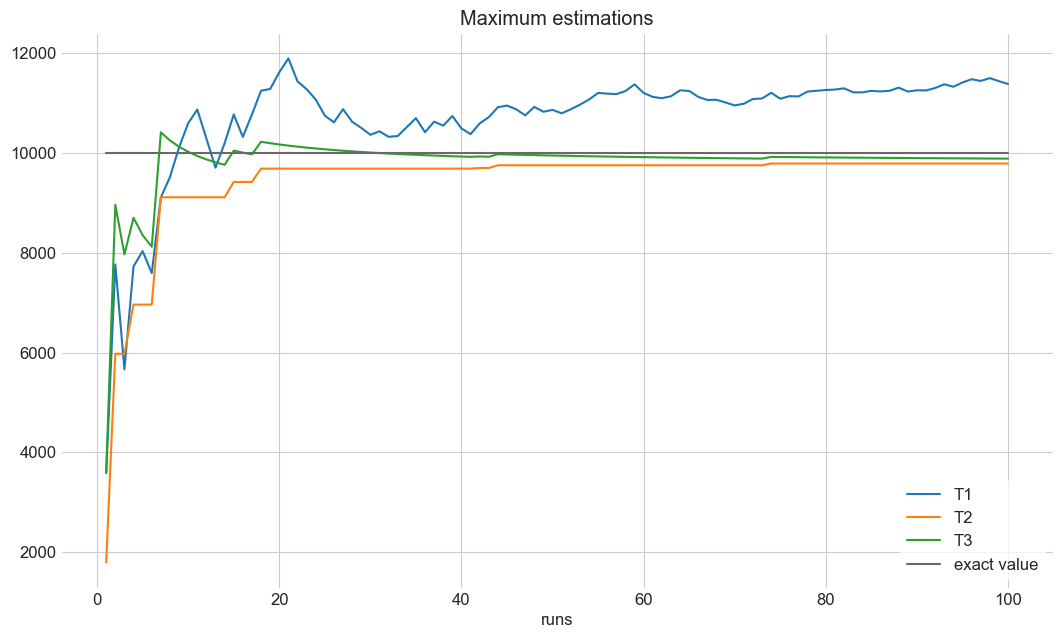

In [15]:
true_maximum = 10_000
runs = 100

t = estimateMax(true_maximum, runs)
x = np.arange(1, runs+1)

plt.plot(x, t[0], label="T1")
plt.plot(x, t[1], label="T2")
plt.plot(x, t[2], label="T3")
plt.plot(x, true_maximum*np.ones(runs), "dimgray", label="exact value")
plt.xlabel("runs")
plt.title("Maximum estimations")
plt.legend()
plt.show()

### Maximum Likelihood Schätzer

Wir suchen die Zentren von $n$ Normalverteilungen. Dazu betrachten wir das Modell $\big(\mathcal{X},\ \mathcal{F},\ \mathcal{P}\big) = \big((\mathbb{R}^2)^n,\ (\mathcal{B}_{\mathbb{R}^2})^n,\ (\sum_{i=1}^n c_i\cdot P_i)^n\big)$, wobei $P_i = \mathcal{N}(m_i, \sigma_i^2)$ und $\sum_{i=1}^n c_i = 1$ für $c_i \ge 0$ ist, und nutzen dafür den Maximum Likelihood Schätzer.

In [25]:
def estimateCenters(num, samples):
    nd = np.zeros((samples, 3))
    
    for k in range(samples):
        nd[k,0] = 5 * rand() # x value
        nd[k,1] = 5 * rand() # y value
        nd[k,2] = 0.075 # sigma
        
    true_centers = nd[-num:, 0:-1]
    
    points = np.zeros((samples, 2))
    for k in range(samples):
        ctr = randint(num) + 1
        newpoint = np.sqrt(2 * nd[-ctr, 2]) * normal(size=2) + nd[-ctr, 0:-1]
        points[k] = newpoint
    
    A = np.zeros((samples, samples))
    for j in range(samples):
        for distr in range(samples):
            x = nd[distr, 0]
            y = nd[distr, 1]
            sigma = nd[distr, 2]
            A[j, distr] = (1/(2 * np.pi * sigma**2) * np.exp(-(points[j, 0] - x)**2 / (2 * sigma**2))
                           * np.exp(-(points[j, 1] - y)**2 / (2 * sigma**2)))
    b = np.ones(samples)
    sol = OMP(A, b, n_nonzero_coefs=num)  # solver not optimal
    ind = np.nonzero(sol)
    centers = nd[ind,0:-1][0]
    
    plt.scatter(*points.T, color="C0", alpha=0.1, label="Samples")
    plt.scatter(*true_centers.T, color="dimgray", label="True centers")
    plt.scatter(*centers.T, color="C1", marker="x", label="Estimated centers")
    
    plt.title("Center estimation")
    plt.legend()
    plt.show()

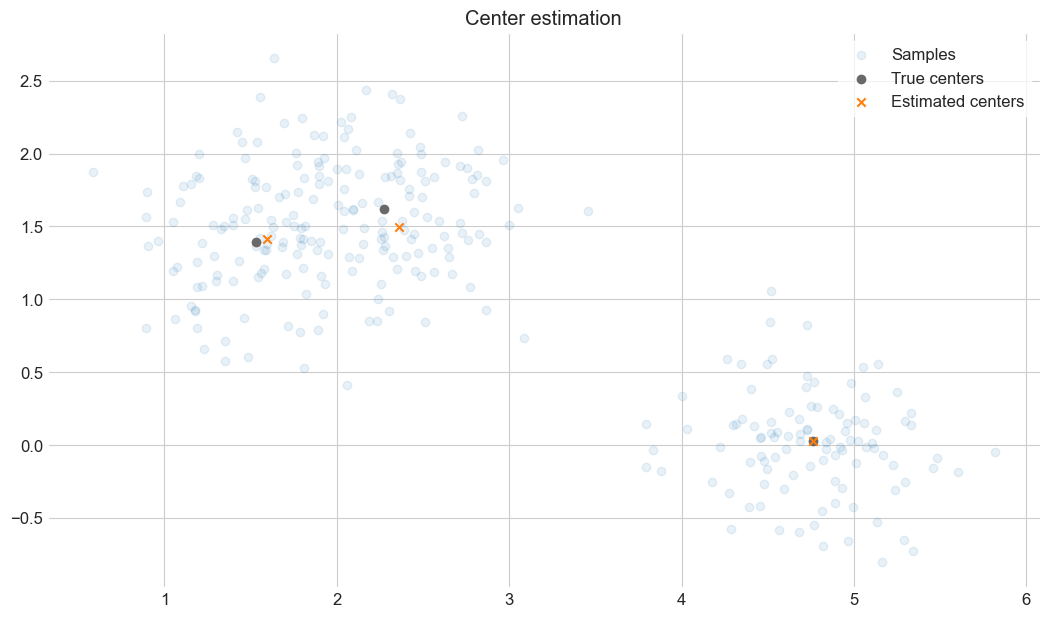

In [29]:
number_of_centers = 3
samples = 100 * number_of_centers

estimateCenters(number_of_centers, samples)